In [1]:
# add capability to import from parent directory
import sys, os
sys.path.insert(1, os.path.join(os.path.abspath('.'), '..'))

import pvmismatch as pvm
import pvlib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

C:\Users\cwhanse\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.1.0' currently installed).
  warnings.warn(msg, UserWarning)


In [20]:
# Setting PV system layout cell and module parameters
v_bypass = np.float64(-0.5)  # [V] trigger voltage of bypass diode
cell_area = np.float64(246.49)  # [cm^2] cell area
Isc0_T0 = 9.68 # [A] reference short circuit current
ncols_per_substr=[2]*3 # 3 bypass diodes each in parallel with 2 series connected cell-columns
nrows=10 # number of cell rows in the module

pvconst = pvm.pvconstants.PVconstants(npts=1000)

# Building PV modules and system
pv_mod_pattern = pvm.pvmodule.standard_cellpos_pat(nrows=nrows,
                                                   ncols_per_substr=ncols_per_substr)
pv_mod = pvm.pvmodule.PVmodule(cell_pos=pv_mod_pattern, pvcells=None,
                               pvconst=pvconst, Vbypass=v_bypass, cellArea=cell_area)

for c in pv_mod.pvcells:
    c.update(diode_model = 'pvsyst', aRBD=0.0, bRBD=0.0, Isc0_T0 = Isc0_T0) # updating short circuit currents


In [74]:
# Set mismatch by different irradiance conditions

# bottom 2 rows of cells are shaded
low_irrad = 0.5

low_irrad_cells = [8, 9, 19, 18]
hi_irrad_cells = list(range(0, len(pv_cells)))
for c in low_irrad_cells:
    hi_irrad_cells.remove(c)

pv_mod.setSuns(cells=hi_irrad_cells, Ee=[1]*len(hi_irrad_cells))
pv_mod.setSuns(cells=low_irrad_cells, Ee=[low_irrad]*len(low_irrad_cells))



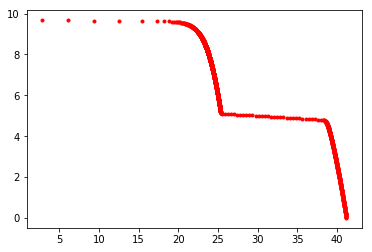

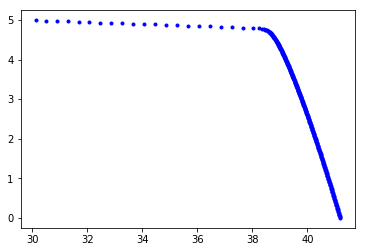

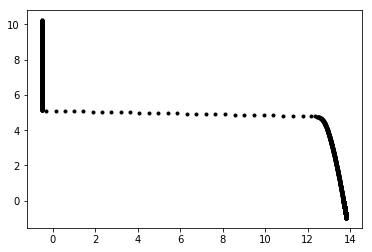

In [75]:
# remove negative voltage and current

u = (pv_mod.Vmod>=0.) & (pv_mod.Imod>=0.)

plt.plot(pv_mod.Vmod[u], pv_mod.Imod[u], 'r.')
plt.show()

uu = (pv_mod.Vmod > 30) & (pv_mod.Imod>=0.)  # focus on segment towards Voc

plt.plot(pv_mod.Vmod[uu], pv_mod.Imod[uu], 'b.')
plt.show()

# plot IV curve for string with shaded cells
plt.plot(pv_mod.Vsubstr[0], pv_mod.Isubstr[0], 'k.')
plt.show()


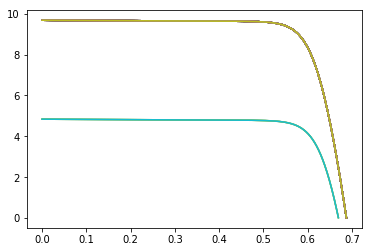

In [76]:

for idx in range(0, 59):
    v = (pv_mod.pvcells[idx].Vcell>=0.) & (pv_mod.pvcells[idx].Icell>=0.)
    plt.plot(pv_mod.pvcells[idx].Vcell[v], pv_mod.pvcells[idx].Icell[v])
plt.show()


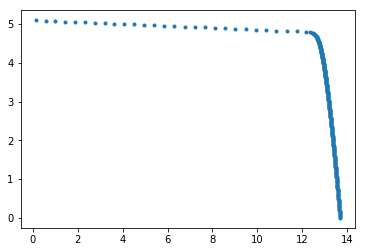

In [79]:
idxs = [r['idx'] for c in pv_mod.cell_pos[0] for r in c]

Icells = []
Vcells = []
for idx in idxs:
    Icells.append(pv_mod.pvcells[idx].Icell)
    Vcells.append(pv_mod.pvcells[idx].Vcell)
Icells = np.asarray(Icells).squeeze()
Vcells = np.asarray(Vcells).squeeze()

Imod, Vmod = pvconst.calcSeries(Icells, Vcells, pv_mod.Isc[idxs].mean(), Isub.max())

u = (Vmod>=0.) & (Imod>=0.)
plt.plot(Vmod[u], Imod[u], '.')
